In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib


df = pd.read_csv("YouTube_Combined_Cleaned (1).csv")
df['published'] = pd.to_datetime(df['published'], errors='coerce', utc=True)
now = pd.Timestamp.utcnow()
df['channel_age_years'] = (now - df['published']).dt.days / 365.25

df['views_per_video'] = np.where(df['videos'] > 0, df['views']/df['videos'], np.nan)
df['subs_per_video']  = np.where(df['videos'] > 0, df['subs']/df['videos'], np.nan)
df['views_per_sub']   = np.where(df['subs'] > 0, df['views']/df['subs'], np.nan)
df['growth_rate']     = np.where(df['channel_age_years'] > 0, df['subs']/df['channel_age_years'], np.nan)

# Keep rows with essential fields
df = df.dropna(subset=['subs','views','videos','channel_age_years'])
y = np.log1p(df['subs'])
features = ['views','videos','channel_age_years',
            'views_per_video','subs_per_video','views_per_sub','growth_rate']
X = np.log1p(df[features].replace([np.inf, -np.inf], np.nan)).fillna(0.0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X.shape, X_train.shape, X_test.shape



((28878, 7), (23102, 7), (5776, 7))

In [16]:
def eval_model(model, Xtr, ytr, Xte, yte, label):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        "model": label,
        "R2_test": r2_score(yte, pred),
        "RMSE_test": mean_squared_error(yte, pred, squared=False)
    }

baseline_results = []

lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
baseline_results.append(eval_model(lr, X_train, y_train, X_test, y_test, "Linear"))
 
rf_quick = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
baseline_results.append(eval_model(rf_quick, X_train, y_train, X_test, y_test, "RF-quick"))

pd.DataFrame(baseline_results)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,R2_test,RMSE_test
0,Linear,0.993053,0.323642
1,RF-quick,0.999981,0.016813


In [20]:

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(max_iter=5000, random_state=42))
])
ridge_grid = {"ridge__alpha": np.logspace(-3, 3, 13)}

ridge_cv = GridSearchCV(
    ridge_pipe, ridge_grid, cv=5, scoring="r2",
    n_jobs=1, verbose=1, error_score="raise"
)
ridge_cv.fit(X_train, y_train)




Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        Ridge(max_iter=5000,
                                              random_state=42))]),
             n_jobs=1,
             param_grid={'ridge__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             scoring='r2', verbose=1)

In [22]:
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=20000, random_state=42))
])
lasso_grid = {"lasso__alpha": np.logspace(-4, 1, 13)}

lasso_cv = GridSearchCV(
    lasso_pipe, lasso_grid, cv=5, scoring="r2",
    n_jobs=1, verbose=1, error_score="raise"
)
lasso_cv.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(max_iter=20000,
                                              random_state=42))]),
             n_jobs=1,
             param_grid={'lasso__alpha': array([1.00000000e-04, 2.61015722e-04, 6.81292069e-04, 1.77827941e-03,
       4.64158883e-03, 1.21152766e-02, 3.16227766e-02, 8.25404185e-02,
       2.15443469e-01, 5.62341325e-01, 1.46779927e+00, 3.83118685e+00,
       1.00000000e+01])},
             scoring='r2', verbose=1)

In [24]:
rf = RandomForestRegressor(random_state=42, n_jobs=1)
rf_grid = {
    "n_estimators": [200],          
    "max_depth": [None, 20],        
    "min_samples_split": [2, 5],    
    "min_samples_leaf": [1, 2],     
    "max_features": ["sqrt"]        
}  

rf_cv = GridSearchCV(
    rf, rf_grid, cv=5, scoring="r2",
    n_jobs=1, verbose=1, error_score="raise"
)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestRegressor(n_jobs=1, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [None, 20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5], 'n_estimators': [200]},
             scoring='r2', verbose=1)

In [26]:
def test_metrics(name, est, Xte, yte):
    pred = est.predict(Xte)
    return {
        "Model": name,
        "R2_test": r2_score(yte, pred),
        "RMSE_test": mean_squared_error(yte, pred, squared=False)
    }

results = []
results.append(test_metrics("Ridge (best)", ridge_cv.best_estimator_, X_test, y_test))
results.append(test_metrics("Lasso (best)", lasso_cv.best_estimator_, X_test, y_test))
results.append(test_metrics("RandomForest (best)", rf_cv.best_estimator_, X_test, y_test))

pd.DataFrame(results).sort_values("R2_test", ascending=False)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,R2_test,RMSE_test
2,RandomForest (best),0.999647,0.072965
0,Ridge (best),0.993053,0.323642
1,Lasso (best),0.993051,0.323685


In [28]:
summary_params = [
    ("Ridge", ridge_cv.best_params_, ridge_cv.best_score_),
    ("Lasso", lasso_cv.best_params_, lasso_cv.best_score_),
    ("RandomForest", rf_cv.best_params_, rf_cv.best_score_)
]
pd.DataFrame(summary_params, columns=["Model","Best Params","CV_R2_mean"])


,Model,Best Params,CV_R2_mean
0,Ridge,{'ridge__alpha': 0.001},0.992883
1,Lasso,{'lasso__alpha': 0.0001},0.992883
2,RandomForest,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.999574


In [30]:
# If a linear model wins (Ridge/Lasso), coefficients ~ elasticities (log-log)
best_linear = ridge_cv if ridge_cv.best_score_ >= lasso_cv.best_score_ else lasso_cv
lin = best_linear.best_estimator_
lin.named_steps  # scaler + model

coefs = lin.named_steps[list(lin.named_steps.keys())[-1]].coef_
coef_table = pd.DataFrame({"feature": X.columns, "coef": coefs}).sort_values("coef", ascending=False)
coef_table


,feature,coef
6,growth_rate,3.166950
4,subs_per_video,0.773293
0,views,0.487249
2,channel_age_years,0.229362
5,views_per_sub,0.151706
1,videos,0.150921
3,views_per_video,-0.684990


In [32]:
# If RF wins, show feature importances
best_rf = rf_cv.best_estimator_
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)
imp


,feature,importance
6,growth_rate,0.386702
0,views,0.248787
4,subs_per_video,0.177086
3,views_per_video,0.100191
1,videos,0.071091
5,views_per_sub,0.013277
2,channel_age_years,0.002866


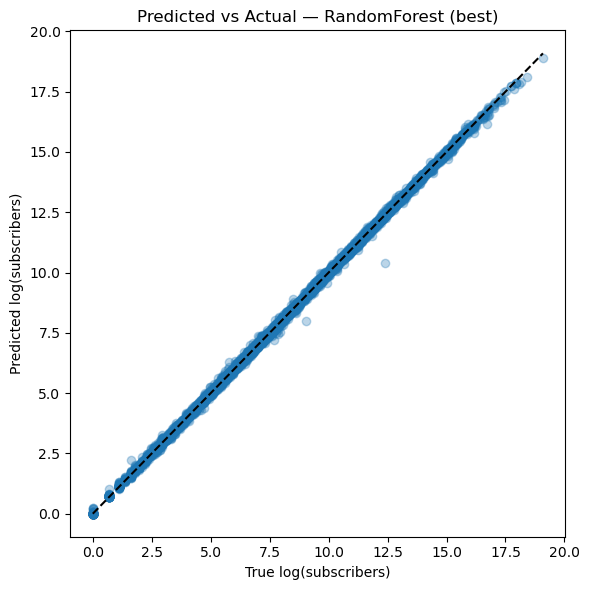

Best model: RandomForest (best)
Test R2: 0.9996468825824246
Test RMSE: 0.07296528684231994


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
# Pick the best overall model by test R^2
tested = pd.DataFrame(results).sort_values("R2_test", ascending=False).iloc[0]
best_name = tested["Model"]

best_est = {
    "Ridge (best)": ridge_cv.best_estimator_,
    "Lasso (best)": lasso_cv.best_estimator_,
    "RandomForest (best)": rf_cv.best_estimator_
}[best_name]

y_pred = best_est.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
minv, maxv = float(np.minimum(y_test.min(), y_pred.min())), float(np.maximum(y_test.max(), y_pred.max()))
plt.plot([minv, maxv], [minv, maxv], 'k--')
plt.xlabel("True log(subscribers)")
plt.ylabel("Predicted log(subscribers)")
plt.title(f"Predicted vs Actual — {best_name}")
plt.tight_layout()
plt.show()

print(f"Best model: {best_name}")
print("Test R2:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))


In [36]:
joblib.dump(best_est, "best_youtube_subs_model.joblib")

pred_df = pd.DataFrame({
    "channel_title": df.iloc[X_test.index]['channel_title'].values if 'channel_title' in df.columns else X_test.index.astype(str),
    "true_log_subs": y_test.values,
    "pred_log_subs": y_pred
})
pred_df.to_csv("predictions_test_set.csv", index=False)

"Saved best_youtube_subs_model.joblib and predictions_test_set.csv"


'Saved best_youtube_subs_model.joblib and predictions_test_set.csv'